In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sys
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

from datetime import datetime
import cv2
from collections import OrderedDict


In [2]:
def get_mean_timeseries(data):
    agg_data = data[data["window"] == "obs"].groupby('key').agg({'hr': 'mean',
                                        'spo2': 'mean',                                       
                                        'abp_sys': 'mean',
                                        'abp_dias': 'mean',
                                        'abp_mean': 'mean'})
    agg_data = agg_data.rename(columns={"hr": "mean_hr", 
                            "spo2": "mean_spo2",                           
                            "abp_sys": "mean_sap",
                            "abp_dias": "mean_dap",
                            "abp_mean": "mean_map"})    
    return(agg_data)

def pick_a_sample(data, k=1):
        """ Picks sample with the same number of observations per patient"""
        np.random.seed(3)
        sample = data.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = sample.copy()
        return sample

def compute_cost(X, y, params):
    n_samples = len(y)
    h = X @ params
    return (1/(2*n_samples))*np.sum((h-y)**2)

def gradient_descent(X, y, params, learning_rate, n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))
    
    for i in range(n_iters):
        params = params - (learning_rate/n_samples) * X.T @ (X @ params - y) 
        J_history[i] = compute_cost(X, y, params)
 
    return (J_history, params)

### Data processing
For every subject_id and periode (= key), the average times series are calculated. This operation is done for the training and the validation datasets. 

In [3]:
PATH = Path("/home/menyssa/Recherche/Mimic-III-Yannet/Scripts/Python/multi-task-romain/")
train = pd.read_csv("/home/menyssa/Recherche/Mimic-III-Yannet/Data/clean/40min/data_modelisation_5min_gap.csv")
val = pd.read_csv("/home/menyssa/Recherche/Mimic-III-Yannet/Data/lariboisiere/data_validation_40.csv")

In [4]:
agg_train = get_mean_timeseries(train)
agg_val = get_mean_timeseries(val)

In [5]:
columns = ['subject_id','key','periode','gender', 'age', 'sapsii', 'sofa', 
           'care_unit', 'amine', 'sedation', 'ventilation', 
           'prediction_mean_MAP', 'prediction_mean_HR']
df_train = train[columns].merge(agg_train, left_on="key", right_on="key").drop_duplicates()
df_val = val[columns].merge(agg_val, left_on="key", right_on="key").drop_duplicates()

In [6]:
num_subjects_train = len(np.unique(df_train.subject_id))
num_subjects_val = len(np.unique(df_val.subject_id))
print("There are {} patients in train set and {} patients in the validation set, which represent {} periods in train set and {} periods in the validation set".format(
      num_subjects_train, num_subjects_val, df_train.shape[0], df_val.shape[0]))

There are 2850 patients in train set and 54 patients in the validation set, which represent 75061 periods in train set and 1597 periods in the validation set


In [7]:
df_train.head()

,subject_id,key,periode,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_MAP,prediction_mean_HR,mean_hr,mean_spo2,mean_sap,mean_dap,mean_map
0,20,20_2,2,1,76,22,1,2,0,0,1,66.34,80.00,80.026667,96.196667,123.703333,58.123333,75.810000
40,20,20_5,5,1,76,22,1,2,0,0,1,86.52,80.00,79.933333,98.823333,121.530000,58.693333,76.883333
80,20,20_7,7,1,76,22,1,2,0,0,1,77.96,80.00,80.000000,99.953333,121.010000,53.056667,71.186667
120,20,20_9,9,1,76,22,1,2,0,0,1,90.02,80.00,80.003333,100.000000,152.133333,64.443333,90.433333
160,20,20_10,10,1,76,22,1,2,0,0,1,82.04,80.34,80.000000,99.626667,116.140000,51.803333,67.220000


In [8]:
df_val.head()

,subject_id,key,periode,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_MAP,prediction_mean_HR,mean_hr,mean_spo2,mean_sap,mean_dap,mean_map
0,3,3_1,1,0,82,122,16,5,1,1,1,78.6,91.0,88.866667,99.733333,136.533333,55.566667,75.766667
40,3,3_12,12,0,82,122,16,5,1,1,1,69.8,88.6,87.733333,96.600000,125.900000,46.733333,64.133333
80,3,3_28,28,0,82,122,16,5,1,1,1,69.4,86.6,85.100000,100.000000,161.800000,46.366667,70.133333
120,3,3_45,45,0,82,122,16,5,1,1,1,71.6,85.6,83.100000,94.733333,143.033333,47.533333,67.800000
160,3,3_48,48,0,82,122,16,5,1,1,1,72.8,82.0,83.266667,96.200000,150.500000,49.900000,72.666667


## Part 1 : Simple modelisation (univariate regression)
There are 75,061 periods in the train dataset and 1,597 periods in the validation dataset. But I just wanted to train only one period per patient to see the $R^2$ on a basic model.
#### 1 - Map prediction

In [9]:
# Only one random period per patient
df_train = pick_a_sample(df_train, 1)
df_val = pick_a_sample(df_val , 1)

In [10]:
# Only one feature, the average mean arterial pressure
X = df_train["mean_map"].values
Y = df_train["prediction_mean_MAP"].values
X = np.reshape(X,(-1,1))
Y = np.reshape(Y,(-1,1))

In [11]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1] 
print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print("Total samples in our dataset is: {}".format(X.shape[0]))

The shape of X is: (2850, 1)
The shape of Y is: (2850, 1)
Total samples in our dataset is: 2850


In [12]:
y = Y
n_samples = len(y)
mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X-mu) / sigma
X = np.hstack((np.ones((n_samples,1)),X))
n_features = np.size(X,1)
params = np.zeros((n_features,1))

Initial cost is:  3195.24837354814 

Optimal parameters are: 
 [[78.1810376 ]
 [12.83991813]] 

Final cost is:  [15.16269066]


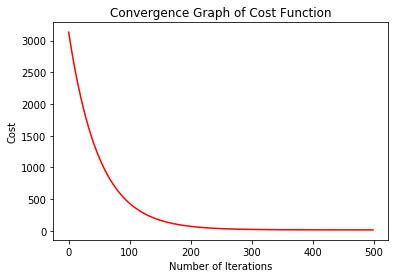

In [13]:
n_iters = 500
learning_rate = 0.01
initial_cost = compute_cost(X, y, params)
print("Initial cost is: ", initial_cost, "\n")
(J_history, optimal_params) = gradient_descent(X, y, params, learning_rate, n_iters)
print("Optimal parameters are: \n", optimal_params, "\n")
print("Final cost is: ", J_history[-1])
plt.plot(range(len(J_history)), J_history, 'r')
plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()


The R^2 on validation set is 0.855885440610221


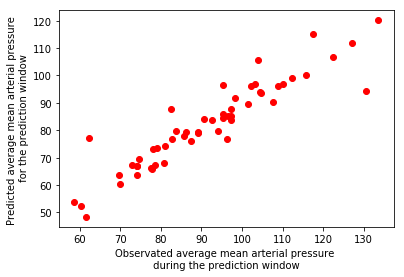

In [18]:
X_val = df_val["mean_map"].values
Y_val = df_val["prediction_mean_MAP"].values
X_val = np.reshape(X_val,(-1,1))
Y_val = np.reshape(Y_val,(-1,1))

y_val = Y_val
n_samples = len(y_val)
mu = np.mean(X_val, 0)
sigma = np.std(X_val, 0)
X_val = (X_val-mu) / sigma
X_val = np.hstack((np.ones((n_samples,1)),X_val))

# predicted values 
y_hat = X_val @ optimal_params

# rsquare
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(y_hat, y_val)
r_square = reg.score(y_hat, y_val)
print("The R^2 on validation set is {}".format(r_square))
plt.plot(y_val, y_hat, 'ro')
plt.xlabel("Observated average mean arterial pressure \n during the prediction window ")
plt.ylabel("Predicted average mean arterial pressure \n for the prediction window")
plt.show()

#### 2 - HR prediction

The R^2 on validation set is 0.8877124245498537


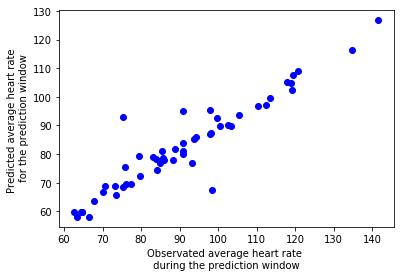

In [19]:
# Only one feature, the average heart rate

# # Training data
X = df_train["mean_hr"].values
Y = df_train["prediction_mean_HR"].values
X = np.reshape(X,(-1,1))
Y = np.reshape(Y,(-1,1))
y = Y
n_samples = len(y)
mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X-mu) / sigma
X = np.hstack((np.ones((n_samples,1)),X))
n_features = np.size(X,1)
params = np.zeros((n_features,1))

# Model
(J_history, optimal_params) = gradient_descent(X, y, params, learning_rate, n_iters)

# Validation data
X_val = df_val["mean_hr"].values
Y_val = df_val["prediction_mean_HR"].values
X_val = np.reshape(X_val,(-1,1))
Y_val = np.reshape(Y_val,(-1,1))
y_val = Y_val
n_samples = len(y_val)
mu = np.mean(X_val, 0)
sigma = np.std(X_val, 0)
X_val = (X_val-mu) / sigma
X_val = np.hstack((np.ones((n_samples,1)),X_val))

# predicted values 
y_hat = X_val @ optimal_params

# rsquare
reg = LinearRegression().fit(y_hat, y_val)
r_square = reg.score(y_hat, y_val)
print("The R^2 on validation set is {}".format(r_square))
plt.plot(y_val, y_hat, 'bo')
plt.xlabel("Observated average heart rate \n during the prediction window ")
plt.ylabel("Predicted average heart rate \n for the prediction window")
plt.show()

### Conclusion 
With only the average mean arterial pressure as a predictor of the average mean arterial pressure during the prediction window, we get a high $R²$ on the validation data. Same thing for the average heart rate

## Part 2
### Multivariate regression
